In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## IMPORTING LIBRARIES

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## DATALOADER

### LOAD/DOWNLOAD DATASET

In [0]:
! cp -r '/content/drive/My Drive/Assignment 5 Dataset'

# !gdown https://drive.google.com/uc?id=1j9bZ2drKlr_btZEBR-melf2RHUWhAPSv
# !unzip /content/Assignment5Data.zip 

data_dir = '/content/Assignment 5 Dataset'


Permission denied: https://drive.google.com/uc?id=1j9bZ2drKlr_btZEBR-melf2RHUWhAPSv
Maybe you need to change permission over 'Anyone with the link'?


### Calculating Mean and Std for Normalizing Images

In [0]:
# train_data = datasets.ImageFolder(data_dir + '/train', transform=transforms.ToTensor())

# mean = torch.zeros(size=(1,3))
# meansq = torch.zeros(size=(1,3))
# # meansq = 
# for data,_ in train_data:
#   mean += data.mean([1,2])
#   meansq += data.pow(2).mean([1,2])

# mean = mean/len(train_data)
# meansq = meansq/len(train_data)
# std = torch.sqrt(meansq-mean.pow(2))
# print(mean)
# print(std)

# tensor([[0.4905, 0.4905, 0.4906]])
# tensor([[0.2494, 0.2494, 0.2494]])


### DATALOADER

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4905, 0.4905, 0.4906],
                                                            [0.2494, 0.2494, 0.2494])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.4905, 0.4905, 0.4906],
                                                           [0.2494, 0.2494, 0.2494])])


#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
batch_size =32
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


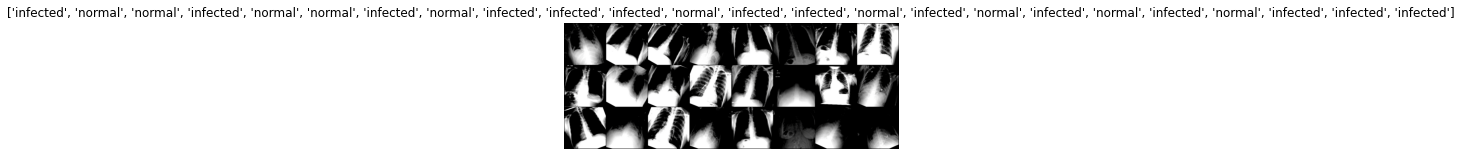

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## LOAD MODEL

In [0]:
def initialize_model(model,freeze):
    if model == 'res18':
        res18 = models.resnet18(pretrained=True)
        fc1_in = res18.fc.in_features

        if freeze == 'all':
            for param in res18.parameters():
                param.requires_grad=False
        elif freeze == 'partial':
            for param in list(res18.parameters())[:-17]:
                param.requires_grad=False
        elif freeze == 'none':
            pass


    elif model == 'vgg16':
        vgg16 == models.vgg16(pretrained=True)
        fc1_in = vgg16.classifier[0].in_features

        if freeze == 'all':
            for param in vgg16.features.parameters():
                param.requires_grad = False
        elif freeze == 'partial':
            for param in list(vgg16.features.parameters())[:-6]:
                param.requires_grad = False
        elif freeze == 'none':
            pass


    fc1_out = 5*10+100
    fc2_in = fc1_out
    fc2_out = 2
    features = [nn.Linear(fc1_in,fc1_out,bias=True),nn.ReLU(inplace=True),nn.Dropout(p=0.5,inplace=False),nn.Linear(fc2_in,fc2_out,bias=True)]

    if model=='res18':
        res18.fc = nn.Sequential(*features)
        return res18
    if model == 'vgg16':
        vgg16.classifier = nn.Sequential(*features)
        if pretarined_weights != None:
          vgg16.load_state_dict(torch.load(pretrained_weights)['state_dict'])
        return vgg16

net = 'vgg16'
freeze = 'none'
model = initialize_model(net,freeze)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Loading from Pretrained Weights

In [0]:
path = '/content/trained_models/vgg16_ft_89.73_0.18_11.pth'
model.load_state_dict(torch.load(path)['state_dict'])

### Loss fucntion and optimizer

In [0]:
Epochs = 50
criterion = nn.CrossEntropyLoss()
lr = 1e-5
optimizer = optim.SGD(vgg16.parameters(), lr=lr, momentum=0.9)

NameError: ignored

## TRAINING

In [0]:
os.mkdir('/content/trained_models')
path = '/content/trained_models'

In [0]:
from tqdm import tqdm
# from pytorchtools import EarlyStopping
import torch.nn.functional as F

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
val_loss_min= 1e6
val_acc_prev = 0.0

epoch_lr = []
epoch_tacc = []
epoch_tloss = []
epoch_vacc= []
epoch_vloss = []

# epoch_lr =[1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5]

for epoch in range(Epochs):  # loop over the dataset multiple times
    val_accuracy =  0.0
    train_accuracy = 0.0

    epoch_lr.append(lr)
    running_loss = 0.0
    # pbar = tqdm(total = len(trainloader))
    
    # pbar = tqdm(len(trainloader))
    
    
    model.train()
    pbar = tqdm(enumerate(trainloader),position=0,leave=True)
    # for i, data in pbar:
    for i,data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        # print(i," ",loss.item())
        pred = torch.argmax(F.softmax(outputs),dim=1)
        # pred = torch.argmax(outputs,dim=1).float()
        # print("PREDICTION",pred)
        # print("LABELS",labels)
        correct = (pred==labels).float().sum()
        # print("CORRECT",correct)
        accuracy = correct*100/inputs.shape[0]
        train_accuracy += correct


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.1f}%'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item(),accuracy),refresh=False)
        
    print("\nTraining Loss of Epoch ",epoch," is :",running_loss)
    tacc= train_accuracy*100/len(trainloader.dataset)
    print("Training Accuracy of Epoch ",epoch," is :",tacc.item(),"\n\n")
    

    epoch_tacc.append(tacc.item())
    epoch_tloss.append(running_loss)

    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valloader),position=0,leave=True)
    # for i, data in pbar:
    for i,data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        # optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        # loss.backward()                     #----> backward pass
        # optimizer.step()                    #----> weights update

        # print statistics
        val_loss += loss.item()
        # print(i," ",loss.item())
        
        pred = torch.argmax(outputs,dim=1)
        correct = (pred==labels).float().sum()
        # print(correct)
        accuracy = correct*100/inputs.shape[0]
        val_accuracy += correct
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.1f}%'.format(
                epoch, i * len(inputs), len(valloader.dataset),
                100. * i / len(valloader),
                loss.data.item(),accuracy),refresh=False)
        
    print("\nValidation Loss of Epoch ",epoch," is :",val_loss)
    acc = val_accuracy*100/len(valloader.dataset)
    print("Validation Accuracy of Epoch ",epoch," is :",acc.item(),"\n\n")

    epoch_vloss.append(val_loss)
    epoch_vacc.append(acc.item())

    if val_loss < val_loss_min:
        checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': val_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }

        val_loss_min = val_loss
        # save_ckp(checkpoint, False, checkpoint_path, best_model_path)


            # pbar.update()
            # pbar()
        torch.save(checkpoint, os.path.join(path,'vgg16_ft_{:.2f}_{:.2f}_{}.pth'.format(acc,loss,epoch)))

    delta = abs(acc.item() - val_acc_prev)
    val_acc_prev = acc.item()

    if (delta < 0.4)and(lr<0.1):
        lr = lr*10
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
print('Finished Training')

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Train Epoch: 0 [464/3716 (99%)]	Loss: 0.585611	Accuracy: 75.0%: : 117it [02:03,  1.06s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  0  is : 75.77980092167854
Training Accuracy of Epoch  0  is : 61.30247497558594 




Validation Epoch: 0 [1288/1500 (98%)]	Loss: 0.567216	Accuracy: 67.9%: : 47it [00:29,  1.60it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  0  is : 28.526807487010956
Validation Accuracy of Epoch  0  is : 61.133331298828125 




Train Epoch: 1 [464/3716 (99%)]	Loss: 0.398573	Accuracy: 100.0%: : 117it [02:05,  1.07s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  1  is : 67.44806763529778
Training Accuracy of Epoch  1  is : 69.9407958984375 




Validation Epoch: 1 [1288/1500 (98%)]	Loss: 0.617502	Accuracy: 64.3%: : 47it [00:29,  1.58it/s]



Validation Loss of Epoch  1  is : 25.66409146785736
Validation Accuracy of Epoch  1  is : 73.86666870117188 




Train Epoch: 2 [464/3716 (99%)]	Loss: 0.552303	Accuracy: 75.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  2  is : 60.158972561359406
Training Accuracy of Epoch  2  is : 78.33692169189453 




Validation Epoch: 2 [1288/1500 (98%)]	Loss: 0.469566	Accuracy: 71.4%: : 47it [00:30,  1.57it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  2  is : 23.012985736131668
Validation Accuracy of Epoch  2  is : 79.73332977294922 




Train Epoch: 3 [464/3716 (99%)]	Loss: 0.570835	Accuracy: 50.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  3  is : 53.188664615154266
Training Accuracy of Epoch  3  is : 82.72335815429688 




Validation Epoch: 3 [1288/1500 (98%)]	Loss: 0.341001	Accuracy: 85.7%: : 47it [00:29,  1.57it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  3  is : 20.823979169130325
Validation Accuracy of Epoch  3  is : 82.53333282470703 




Train Epoch: 4 [464/3716 (99%)]	Loss: 0.284490	Accuracy: 100.0%: : 117it [02:06,  1.08s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  4  is : 48.39044734835625
Training Accuracy of Epoch  4  is : 83.93433380126953 




Validation Epoch: 4 [1288/1500 (98%)]	Loss: 0.373709	Accuracy: 85.7%: : 47it [00:29,  1.58it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  4  is : 19.43631738424301
Validation Accuracy of Epoch  4  is : 82.79999542236328 




Train Epoch: 5 [464/3716 (99%)]	Loss: 0.685633	Accuracy: 50.0%: : 117it [02:09,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  5  is : 41.375961273908615
Training Accuracy of Epoch  5  is : 86.14100646972656 




Validation Epoch: 5 [1288/1500 (98%)]	Loss: 0.202560	Accuracy: 89.3%: : 47it [00:30,  1.56it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  5  is : 15.684556245803833
Validation Accuracy of Epoch  5  is : 86.19999694824219 




Train Epoch: 6 [464/3716 (99%)]	Loss: 0.053980	Accuracy: 100.0%: : 117it [02:08,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  6  is : 34.200719341635704
Training Accuracy of Epoch  6  is : 88.50914764404297 




Validation Epoch: 6 [1288/1500 (98%)]	Loss: 0.277982	Accuracy: 89.3%: : 47it [00:30,  1.56it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  6  is : 15.205866113305092
Validation Accuracy of Epoch  6  is : 87.19999694824219 




Train Epoch: 7 [464/3716 (99%)]	Loss: 0.090906	Accuracy: 100.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  7  is : 29.496006913483143
Training Accuracy of Epoch  7  is : 90.50053405761719 




Validation Epoch: 7 [1288/1500 (98%)]	Loss: 0.362831	Accuracy: 82.1%: : 47it [00:30,  1.56it/s]



Validation Loss of Epoch  7  is : 13.579499527812004
Validation Accuracy of Epoch  7  is : 87.5999984741211 




Train Epoch: 8 [464/3716 (99%)]	Loss: 0.025103	Accuracy: 100.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  8  is : 27.3598687723279
Training Accuracy of Epoch  8  is : 90.87728881835938 




Validation Epoch: 8 [1288/1500 (98%)]	Loss: 0.221842	Accuracy: 92.9%: : 47it [00:30,  1.56it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  8  is : 12.850800313055515
Validation Accuracy of Epoch  8  is : 88.5999984741211 




Train Epoch: 9 [464/3716 (99%)]	Loss: 0.592223	Accuracy: 75.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  9  is : 26.122021086513996
Training Accuracy of Epoch  9  is : 91.71151733398438 




Validation Epoch: 9 [1288/1500 (98%)]	Loss: 0.323805	Accuracy: 85.7%: : 47it [00:30,  1.55it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  9  is : 12.475084632635117
Validation Accuracy of Epoch  9  is : 88.66666412353516 




Train Epoch: 10 [464/3716 (99%)]	Loss: 0.272903	Accuracy: 75.0%: : 117it [02:08,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  10  is : 29.514517337083817
Training Accuracy of Epoch  10  is : 90.20452117919922 




Validation Epoch: 10 [1288/1500 (98%)]	Loss: 0.319358	Accuracy: 85.7%: : 47it [00:30,  1.55it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  10  is : 12.158783569931984
Validation Accuracy of Epoch  10  is : 89.66666412353516 




Train Epoch: 11 [464/3716 (99%)]	Loss: 0.052940	Accuracy: 100.0%: : 117it [02:08,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  11  is : 26.177328623831272
Training Accuracy of Epoch  11  is : 91.38858795166016 




Validation Epoch: 11 [1288/1500 (98%)]	Loss: 0.176178	Accuracy: 92.9%: : 47it [00:30,  1.55it/s]



Validation Loss of Epoch  11  is : 11.49648666381836
Validation Accuracy of Epoch  11  is : 89.73332977294922 




Train Epoch: 12 [464/3716 (99%)]	Loss: 0.638568	Accuracy: 75.0%: : 117it [02:08,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  12  is : 44.4586790651083
Training Accuracy of Epoch  12  is : 84.9300308227539 




Validation Epoch: 12 [1288/1500 (98%)]	Loss: 0.493858	Accuracy: 71.4%: : 47it [00:30,  1.55it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  12  is : 18.587394282221794
Validation Accuracy of Epoch  12  is : 80.66666412353516 




Train Epoch: 13 [464/3716 (99%)]	Loss: 0.275748	Accuracy: 75.0%: : 117it [02:05,  1.07s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  13  is : 36.794055208563805
Training Accuracy of Epoch  13  is : 87.75564575195312 




Validation Epoch: 13 [1288/1500 (98%)]	Loss: 0.201718	Accuracy: 92.9%: : 47it [00:29,  1.58it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  13  is : 12.42156833410263
Validation Accuracy of Epoch  13  is : 88.66666412353516 




Train Epoch: 14 [464/3716 (99%)]	Loss: 0.315154	Accuracy: 75.0%: : 117it [02:05,  1.08s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  14  is : 32.00921990349889
Training Accuracy of Epoch  14  is : 90.04305267333984 




Validation Epoch: 14 [1288/1500 (98%)]	Loss: 0.140058	Accuracy: 92.9%: : 47it [00:29,  1.58it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  14  is : 11.74388950318098
Validation Accuracy of Epoch  14  is : 89.26666259765625 




Train Epoch: 15 [464/3716 (99%)]	Loss: 0.205531	Accuracy: 75.0%: : 117it [02:05,  1.08s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  15  is : 29.47081844136119
Training Accuracy of Epoch  15  is : 90.28524780273438 




Validation Epoch: 15 [1288/1500 (98%)]	Loss: 0.308966	Accuracy: 85.7%: : 47it [00:29,  1.58it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  15  is : 12.133703902363777
Validation Accuracy of Epoch  15  is : 88.79999542236328 




Train Epoch: 16 [464/3716 (99%)]	Loss: 0.676500	Accuracy: 75.0%: : 117it [02:06,  1.08s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  16  is : 25.41735451668501
Training Accuracy of Epoch  16  is : 91.98062133789062 




Validation Epoch: 16 [1288/1500 (98%)]	Loss: 0.417651	Accuracy: 85.7%: : 47it [00:29,  1.58it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  16  is : 12.809466324746609
Validation Accuracy of Epoch  16  is : 89.73332977294922 




Train Epoch: 17 [464/3716 (99%)]	Loss: 0.106018	Accuracy: 100.0%: : 117it [02:07,  1.09s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  17  is : 27.16258654743433
Training Accuracy of Epoch  17  is : 91.6576919555664 




Validation Epoch: 17 [1288/1500 (98%)]	Loss: 0.379210	Accuracy: 89.3%: : 47it [00:30,  1.55it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  17  is : 13.047089967876673
Validation Accuracy of Epoch  17  is : 88.93333435058594 




Train Epoch: 18 [464/3716 (99%)]	Loss: 0.042318	Accuracy: 100.0%: : 117it [02:08,  1.10s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  18  is : 27.080859050154686
Training Accuracy of Epoch  18  is : 91.63078308105469 




Validation Epoch: 18 [1288/1500 (98%)]	Loss: 0.138097	Accuracy: 96.4%: : 47it [00:30,  1.55it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  18  is : 14.189242511987686
Validation Accuracy of Epoch  18  is : 88.93333435058594 




Train Epoch: 19 [464/3716 (99%)]	Loss: nan	Accuracy: 0.0%: : 117it [02:04,  1.06s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  19  is : nan
Training Accuracy of Epoch  19  is : 43.05704879760742 




Validation Epoch: 19 [1288/1500 (98%)]	Loss: nan	Accuracy: 50.0%: : 47it [00:29,  1.57it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  19  is : nan
Validation Accuracy of Epoch  19  is : 41.0 




Train Epoch: 20 [464/3716 (99%)]	Loss: nan	Accuracy: 50.0%: : 117it [02:04,  1.06s/it]
0it [00:00, ?it/s]


Training Loss of Epoch  20  is : nan
Training Accuracy of Epoch  20  is : 41.8998908996582 




Validation Epoch: 20 [1288/1500 (98%)]	Loss: nan	Accuracy: 42.9%: : 47it [00:29,  1.57it/s]
0it [00:00, ?it/s]


Validation Loss of Epoch  20  is : nan
Validation Accuracy of Epoch  20  is : 41.0 




Train Epoch: 21 [2208/3716 (59%)]	Loss: nan	Accuracy: 37.5%: : 70it [01:14,  1.06s/it]

KeyboardInterrupt: ignored

## EVALUATION

In [0]:
save_path= '/content/drive/My Drive/vgg_results'

### Plot Loss and Accuracy Curves

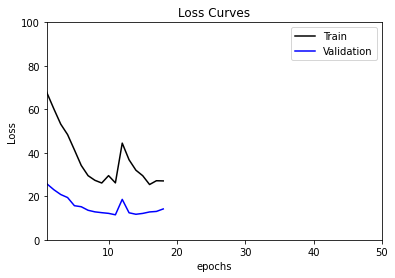

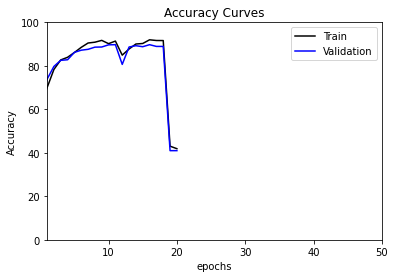

In [0]:
import os.path as osp

# from matplotlib.ticker import MaxNLocator
# Epochs=21
## LOSS AND ACCURACY CURVES ##
plt.figure()
plt.plot(range(Epochs),np.array(epoch_tloss).reshape(Epochs),color='k',label='Train')
plt.plot(range(Epochs),np.array(epoch_vloss).reshape(Epochs),color='b',label='Validation')

# ax=plt.figure().gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Loss Curves')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.ylim(0,100)
plt.xlim(1,50)
# plt.xticks(range(1,22))
plt.legend()

plt.savefig(osp.join(save_path,'Loss Curves.png'),bbox_inches='tight')
################ ACCURACY##################

plt.figure()
plt.plot(range(Epochs),epoch_tacc,color='k',label='Train')
plt.plot(range(Epochs),epoch_vacc,color='b',label='Validation')
plt.ylim(0,100)
plt.xlim(1,50)
# plt.xticks(range(1,22))

plt.title('Accuracy Curves')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(osp.join(save_path,'Accuracy Curves.png'),bbox_inches='tight')

### Evaluate

Accuracy of the network on the 10000 test images: 91 %
F1 SCORE:  0.9340392675932053
Confusion matrix, without normalization


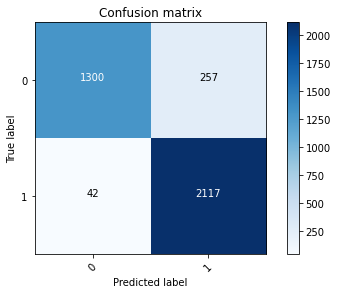

In [0]:
## CONFUSION MATRIX ##


correct = 0
total = 0
predicted = []
gt = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = torch.argmax(outputs,dim=1)
        correct += (pred==labels).float().sum()
        
        predicted.extend(torch.Tensor.cpu(pred).numpy())
        gt.extend(torch.Tensor.cpu(labels).numpy())
        # _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # correct += (pred == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


from sklearn.metrics import confusion_matrix
import pandas as pd
import itertools

# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
# out
# pred=np.argmax(out,axis=1)
cfm = confusion_matrix(gt, predicted)
recall = cfm[1,1]/cfm[1,:].sum()
precision = cfm[1,1]/cfm[:,1].sum()
f1 = (2*precision*recall)/(precision+recall)
print("F1 SCORE: ",f1)
# cfm = pd.DataFrame(cfm,index=np.arange(10),columns=np.arange(10))
# sns.heatmap(cfm,annot=True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cfm, classes=np.arange(2))
plt.savefig(osp.join(save_path,'cfm_train.png'),bbox_inches='tight')



        
